# CO2 Emission Forecasting using ARIMA & SARIMA Model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
import itertools
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [2]:
data = pd.read_csv('MER_T12_06.csv')
data.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLEIEUS,197301,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1,CLEIEUS,197302,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
2,CLEIEUS,197303,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
3,CLEIEUS,197304,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
4,CLEIEUS,197305,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [3]:
print('\nData Information:')
print(data.info())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           5094 non-null   object
 1   YYYYMM        5094 non-null   int64 
 2   Value         5094 non-null   object
 3   Column_Order  5094 non-null   int64 
 4   Description   5094 non-null   object
 5   Unit          5094 non-null   object
dtypes: int64(2), object(4)
memory usage: 238.9+ KB
None


Dataset mempunyai 6 kolom dimana 2 diantaranya adalah data bertipe integer dan 4 object dengan 5096 observasi. Karena kerangka data tersebut bukan dataset time series, maka kita harus mengubah dataset tersebut menjadi data time series seperti di bawah ini

In [4]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors= 'coerce')
df = pd.read_csv('MER_T12_06.csv', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse)
df.head()

,MSN,Value,Column_Order,Description,Unit
YYYYMM,,,,,
1973-01-01,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


Jumlah total emisi dari setiap kelompok energi untuk setiap tahun diberikan sebagai observasi yang dapat dilihat pada NaT row. Jadi pertama kita identifikasi dan drop baris index non datetime, kemudian kita ubah index menjadi datetime, coerce errors, dan filter NaT.

In [5]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head()

,MSN,Value,Column_Order,Description,Unit
YYYYMM,,,,,
1973-01-01,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [6]:
print('Time Series Information:\n')
print(ts.info())

Time Series Information:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           4707 non-null   object
 1   Value         4707 non-null   object
 2   Column_Order  4707 non-null   int64 
 3   Description   4707 non-null   object
 4   Unit          4707 non-null   object
dtypes: int64(1), object(4)
memory usage: 220.6+ KB
None


Seperti yang terlihat dari informasi di atas, emission value direpresentasikan sebagi data object. Oleh karena itu, kita convert menjadi numeric value

In [7]:
ts['Value'] = pd.to_numeric(ts['Value'], errors='coerce')
ts.head()

,MSN,Value,Column_Order,Description,Unit
YYYYMM,,,,,
1973-01-01,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [8]:
print('Time Series Information:\n')
print(ts.info())

Time Series Information:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4707 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4707 non-null   int64  
 3   Description   4707 non-null   object 
 4   Unit          4707 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 220.6+ KB
None


Ternyata terdapat missing values di dalam emission value, maka harus kita drop

In [9]:
ts.dropna(inplace=True)

## Visualization

Bar chart dari CO2 emission setiap sumber energi

In [10]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()
CO2_per_source.index

Index(['Geothermal Energy Electric Power Sector CO2 Emissions',
       'Non-Biomass Waste Electric Power Sector CO2 Emissions',
       'Petroleum Coke Electric Power Sector CO2 Emissions',
       'Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions',
       'Residual Fuel Oil Electric Power Sector CO2 Emissions',
       'Petroleum Electric Power Sector CO2 Emissions',
       'Natural Gas Electric Power Sector CO2 Emissions',
       'Coal Electric Power Sector CO2 Emissions',
       'Total Energy Electric Power Sector CO2 Emissions'],
      dtype='object', name='Description')

In [11]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']

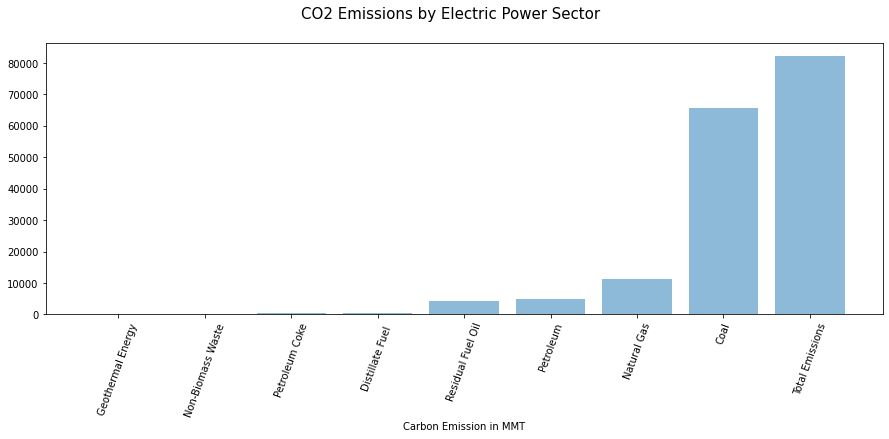

In [12]:
fig = plt.figure(figsize=(15,5))
x_label = cols
x_tick = np.arange(len(cols))
plt.bar(x_tick, CO2_per_source, align = 'center', alpha = 0.5)
fig.suptitle("CO2 Emissions by Electric Power Sector", fontsize=15)
plt.xticks(x_tick, x_label, rotation = 70, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Carbon Emission in MMT', fontsize=10)
#plt.tight_layout()
plt.show()

Dari bar chart di atas, kita dapat melihat Coal Emission memiliki kontribusi significant diikuti oleh Natural Gas

## Total CO2 Emission Analysis

Untuk membangun model time series dan membuat forecasting, kita akan menggunakan total CO2 emission dari electrical power generation. Pertama akan kita slice datanya terlebih dahulu

In [13]:
emissions = ts.iloc[:,1:] 
emissions= emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = emissions['Total Energy Electric Power Sector CO2 Emissions'] # Monthly total emission (mte)
mte

YYYYMM
1973-01-31    111.621
1973-02-28     99.185
1973-03-31     99.112
1973-04-30     93.183
1973-05-31     98.012
               ...   
2016-03-31    115.997
2016-04-30    113.815
2016-05-31    129.440
2016-06-30    172.074
2016-07-31    201.958
Freq: M, Name: Total Energy Electric Power Sector CO2 Emissions, Length: 523, dtype: float64

### Test Stationarity

Arti stasioner adalah apabila suatu data runtut waktu memiliki rata-rata dan memiliki kecenderungan bergerak menuju rata-rata. Apabila data time series tidak stationer, biasanya akan diubah menjadi stationer

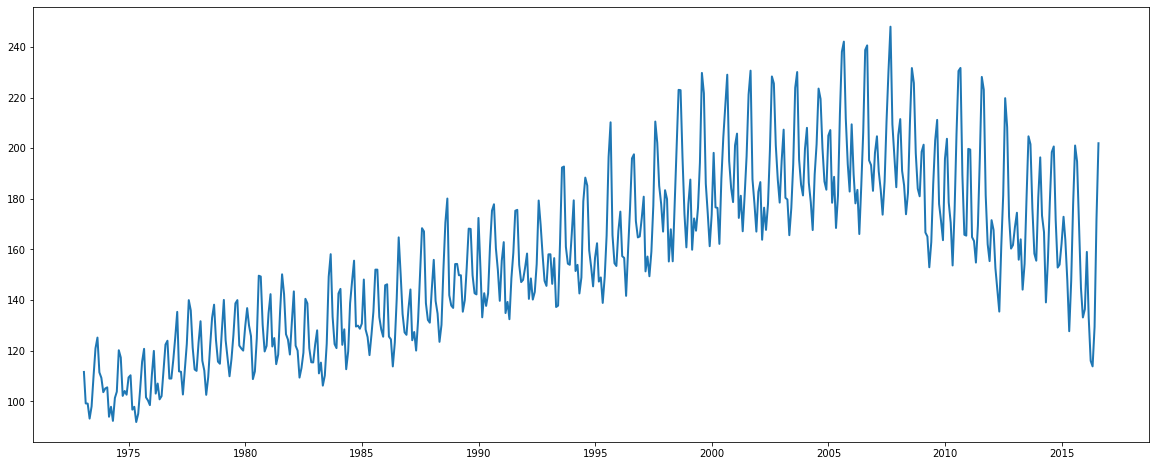

In [14]:
plt.figure(figsize=(20,8))
plt.plot(mte, linewidth=2)
plt.show()

Dari gambar terlihat adanya trend pada dataset emisi CO2 dengan seasonal variation. Jadi, dapat kita simpulkan bahwa dataset tidak stasioner

#### Test Stationarity using Dickey-Fuller

Cara kedua untuk mengetahui stasioneritas dari data time series adalah dengan menggunakan Dickey-Fuller method.

Hipotesis:
- H0 = Data tidak stasioner
- H1 = Data stasioner

In [15]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window=12, center=False).mean()
    rol_std = ts.rolling(window=12, center=False).std()

    plt.figure(figsize=(20,8))
    plt.plot(ts, color='blue', label='Original Data', linewidth=2)
    plt.plot(rol_mean, color='red', label='Rolling Mean', linewidth=2)
    plt.plot(rol_std, color='black', label='Rolling Std', linewidth=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.xlabel('Time in Years', fontsize=15)
    plt.ylabel('Total Emissiions', fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=20)
    plt.show(block=True)

def TestStationaryAdFuller(ts, cutoff=0.01):
    ts_test = adfuller(ts, autolag='AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic', 'p-value', '#Lag Used', 'Number of Observations Used'])

    for key, value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

    if ts_test[1] <= cutoff:
        print("Hipotesis nol ditolak, data stasioner")
    else:
        print("Hipotesis nol diterima, data terindikasi non-stationary")

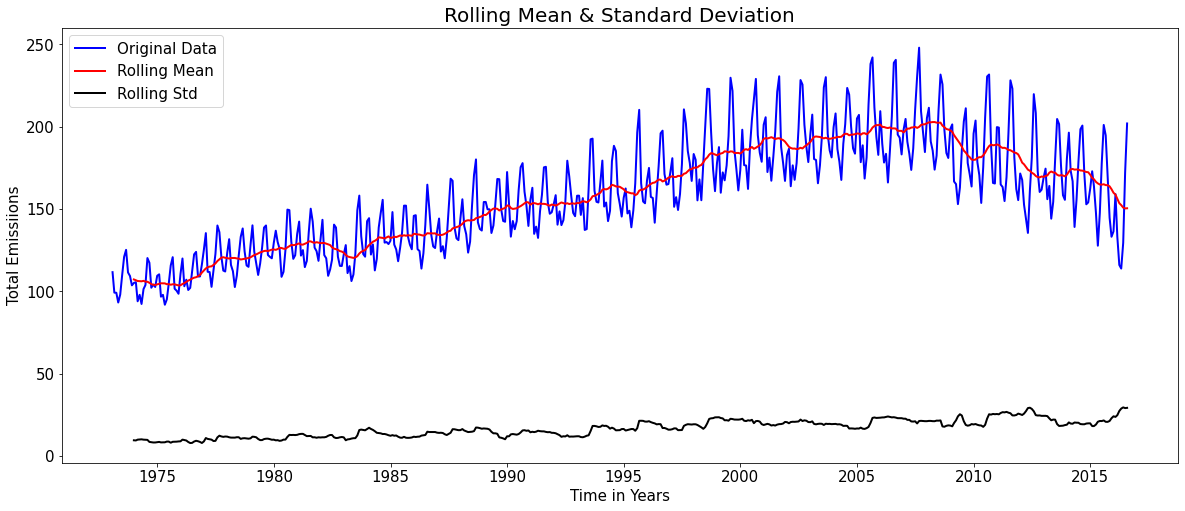

In [16]:
TestStationaryPlot(mte)

In [17]:
TestStationaryAdFuller(mte)

Test Statistic                  -1.809627
p-value                          0.375693
#Lag Used                       14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64
Hipotesis nol diterima, data terindikasi non-stationary


Rata-rata emission dan standar deviasi (garis hitam) jelas bervariasi dengan waktu. Ini menunjukkan bahwa series tersebut memiliki trend. Jadi, data tidak stasioner. Selain itu, test statistic lebih besar dari critical value dengan tingkat confidence 90%, 95%, dan 99%. Oleh karena itu, tidak ada bukti untuk menolak hipotesis nol, sehingga time series tersebut tidak stasioner

### Transform the dataset to stationary

Teknik paling umum yang digunakan untuk estimasi atau memodelkan trend dan menghapusnya dari time series antara lain:
- Aggregation --> mengambil rata-rata untuk periode waktu seperti rata-rata bulanan/mingguan
- Smoothing --> mengambil rolling averages
- Polynomial Fitting --> fit model regresi

#### a) Moving Average

Pada teknik ini, kita mengambil rata-rata nilai 'k' berturut-turut tergantung pada frekuensi time series (dalam kasus ini 12 bulan per tahun). Di sini, kita akan mengambil rata-rata selama 1 tahun terakhir.

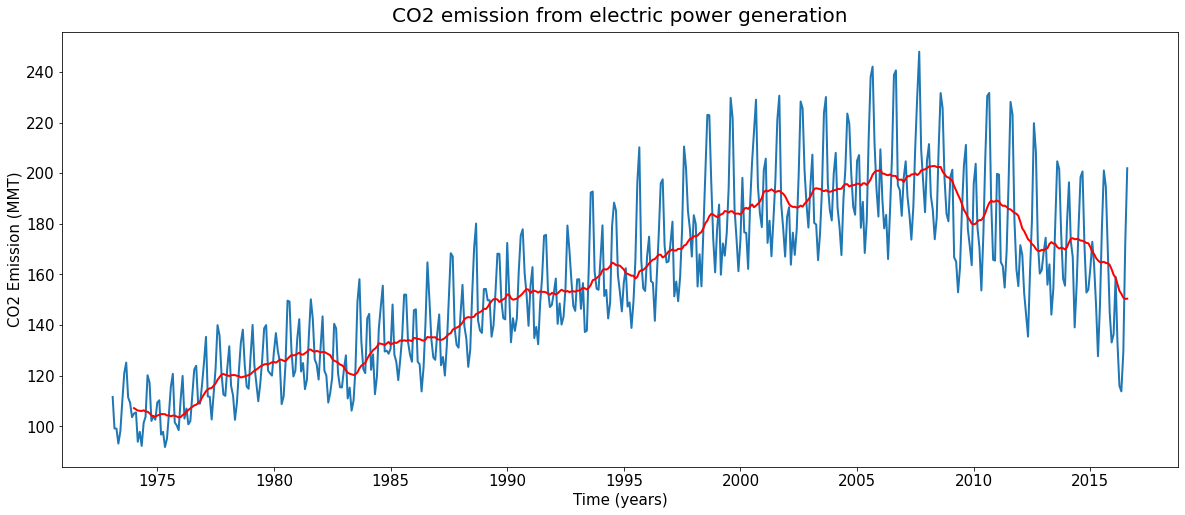

In [18]:
moving_avg = mte.rolling(12).mean()
plt.figure(figsize=(20,8))
plt.plot(mte, linewidth=2)
plt.plot(moving_avg, color='red', linewidth=2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time (years)', fontsize = 15)
plt.ylabel('CO2 Emission (MMT)', fontsize = 15)
plt.title('CO2 emission from electric power generation', fontsize = 20, pad=10)
plt.show()

In [19]:
mte_moving_avg_diff = mte - moving_avg
mte_moving_avg_diff.head(13)

YYYYMM
1973-01-31         NaN
1973-02-28         NaN
1973-03-31         NaN
1973-04-30         NaN
1973-05-31         NaN
1973-06-30         NaN
1973-07-31         NaN
1973-08-31         NaN
1973-09-30         NaN
1973-10-31         NaN
1973-11-30         NaN
1973-12-31   -2.107083
1974-01-31   -1.158500
Freq: M, Name: Total Energy Electric Power Sector CO2 Emissions, dtype: float64

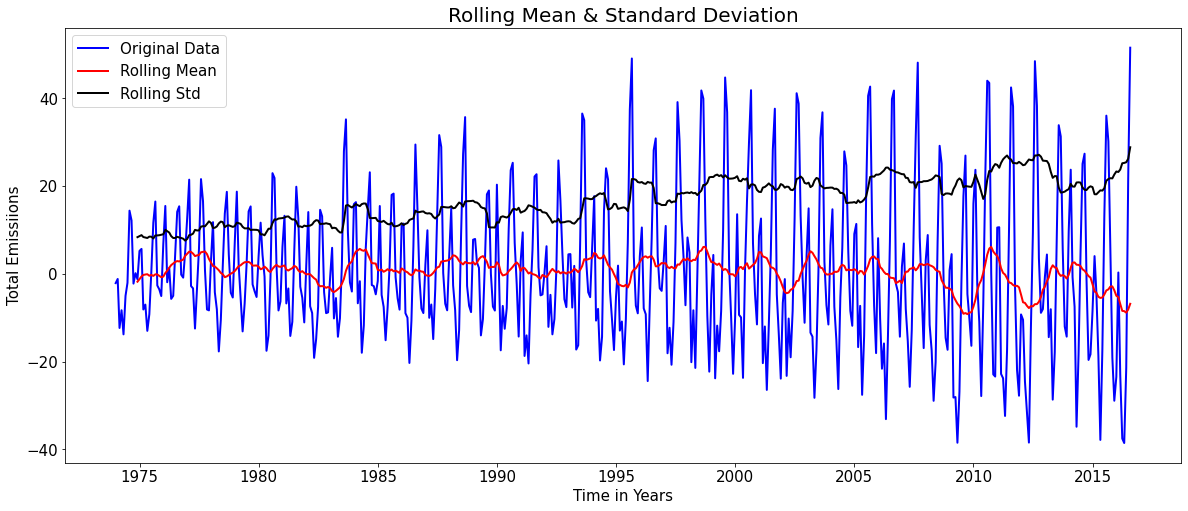

In [20]:
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [21]:
TestStationaryAdFuller(mte_moving_avg_diff)

Test Statistic                -6.289158e+00
p-value                        3.635108e-08
#Lag Used                      1.400000e+01
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64
Hipotesis nol ditolak, data stasioner


Nilai rolling mean tampak sedikit berbeda. Test Statistic lebih kecil dari 10%, 5%, dan 1% dari critical value. Jadi, kita dapat mengatakan dengan tingkat kepercayaan 99% bahwa dataset adalah stasioner

#### b) Exponential Weighted Moving Average

Teknik lainnya adalah dengan mengambil 'weighted moving average' dimana nilai yang lebih baru diberi bobot yang lebih tinggi. Metode populer untuk menetapkan bobot adalah menggunakan exponential weighted moving average. Dimana bobot ditetapkan ke semua nilai sebelumnya dengan decay factor

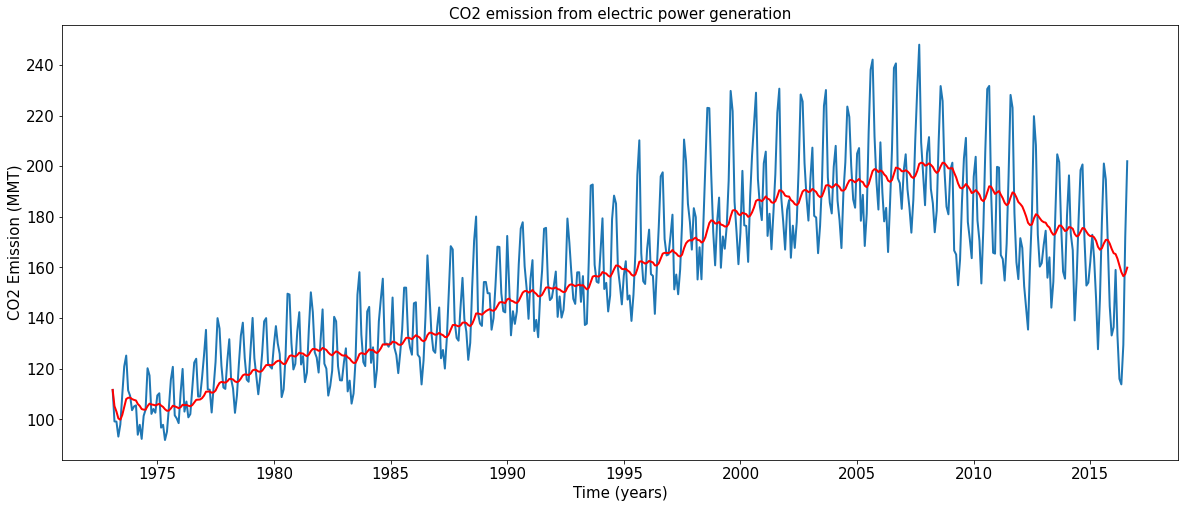

In [22]:
mte_exp_wighted_avg = mte.ewm(halflife=12).mean()
plt.figure(figsize=(20,8))
plt.plot(mte, linewidth=2)
plt.plot(mte_exp_wighted_avg, color='red', linewidth=2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time (years)', fontsize = 15)
plt.ylabel('CO2 Emission (MMT)', fontsize = 15)
plt.title('CO2 emission from electric power generation', fontsize = 15)
plt.show()

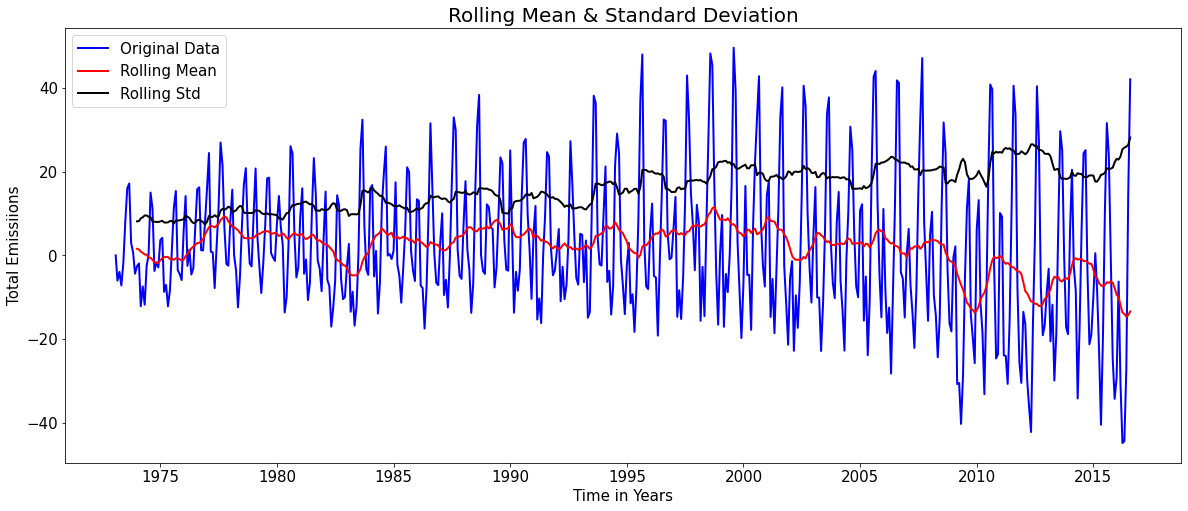

In [23]:
mte_ewma_diff = mte - mte_exp_wighted_avg
TestStationaryPlot(mte_ewma_diff)

In [24]:
TestStationaryAdFuller(mte_ewma_diff)

Test Statistic                  -3.152381
p-value                          0.022912
#Lag Used                       14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64
Hipotesis nol diterima, data terindikasi non-stationary


Time series kali ini memiliki variasi mean dan standar deviasi yang lebih rendah dibandingkan dengan dataset asli. Selain itu, Test Statistik lebih kecil dari critical value 5% dan 10%, yang lebih baik dari kasus aslinya. Tidak ada missing value karena semua value dari awal diberi bobot. Jadi, ini akan berfungsi bahkan tanpa nilai sebelumnya. Dalam hal ini, kita dapat mengatakan dengan tingkat kepercayaan 95% data tersebut stasioner

#### c) Eliminating trend and seasonality : Differencing

Metode paling umum untuk menangani trend dan seasonality adalah differencing. Dalam teknik ini, kami mengambil perbedaan dari observasi original pada saat tertentu dengan saat sebelumnya. Ini sebagian besar bekerja dengan baik untuk meningkatkan stasioneritas.

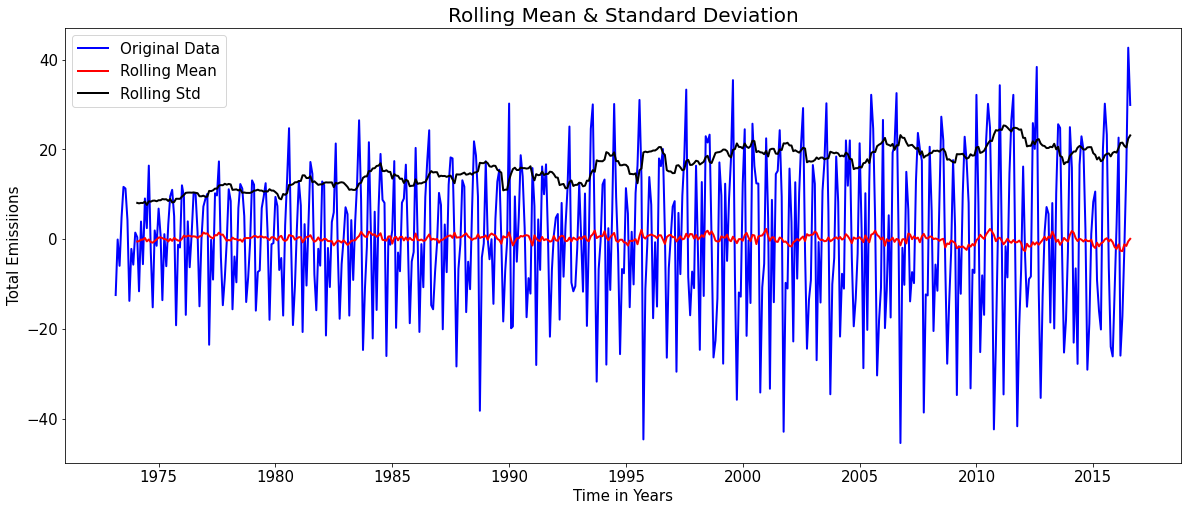

In [25]:
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [26]:
TestStationaryAdFuller(mte_first_difference.dropna(inplace=False))

Test Statistic                -6.610275e+00
p-value                        6.402884e-09
#Lag Used                      1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64
Hipotesis nol ditolak, data stasioner


Difference pertama meningkatkan stasioneritas secara signifikan. Selanjutnya kita gunakan juga seasonal difference dan melihat bagaimana hal itu memengaruhi stasioneritas data

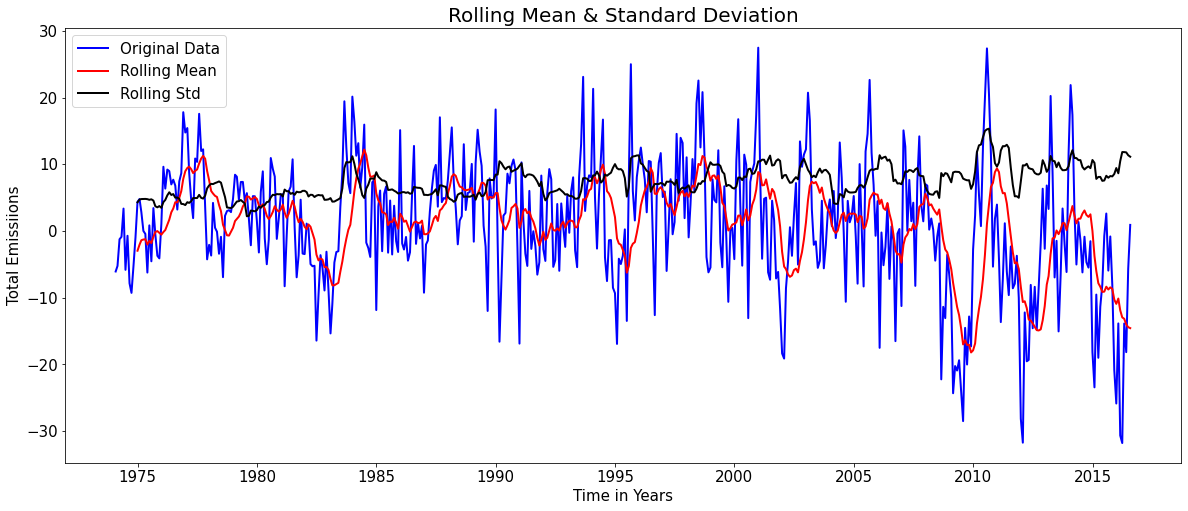

Test Statistic                  -5.495918
p-value                          0.000002
#Lag Used                       12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64
Hipotesis nol ditolak, data stasioner


In [27]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdFuller(mte_seasonal_difference.dropna(inplace=False))

Dibandingkan dengan data asli, seasonal difference juga meningkatkan stasioneritas. Selanjutnya kita akan mengambil difference pertama dari seasonal difference

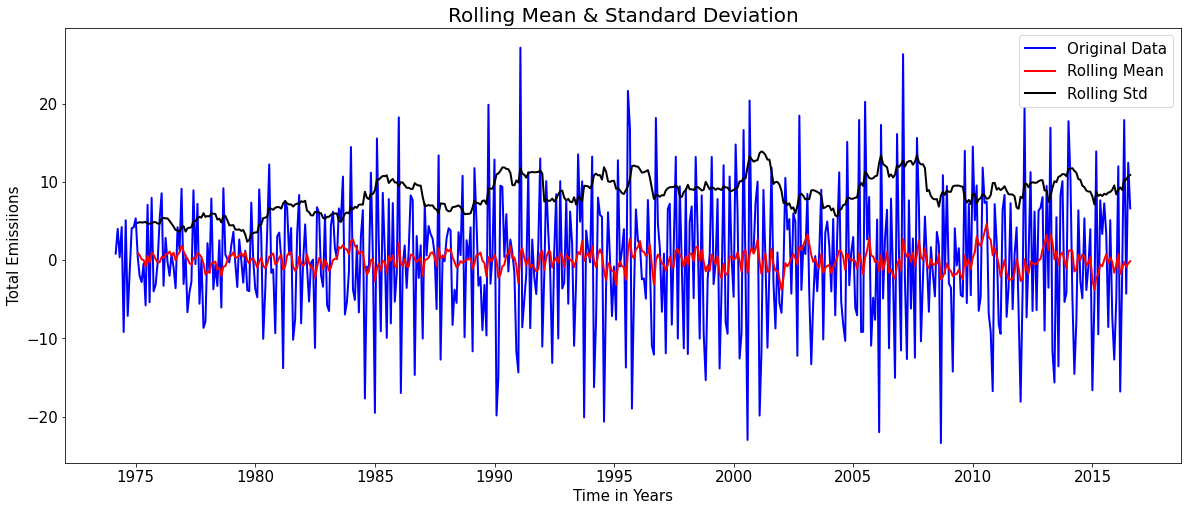

Test Statistic                -8.574894e+00
p-value                        8.012370e-14
#Lag Used                      1.400000e+01
Number of Observations Used    4.950000e+02
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
Critical Value (10%)          -2.569889e+00
dtype: float64
Hipotesis nol ditolak, data stasioner


In [28]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))
TestStationaryAdFuller(mte_seasonal_first_difference.dropna(inplace=False))

Sekarang, jika kita melihat Test Statistic dan p-value, mengambil seasonal difference pertama telah membuat dataset time series kita stasioner. Prosedur difference ini dapat diulang untuk log values, tetapi hal itu tidak membuat dataset lebih stasioner

#### d) Eliminating trend and seasonality : Decomposing

Teknik ini memodelkan trend dan seasonality dan menghapusnya dari model

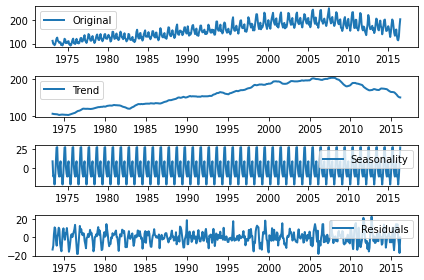

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mte)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mte, label='Original', linewidth=2)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', linewidth=2)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', linewidth=2)
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', linewidth=2)
plt.legend(loc='best')
plt.tight_layout()

Kita bisa melihat bahwa trend dan seasonality dipisahkan dari data dan kita dapat memodelkan residualnya. Sekarang kita cek stasioneritas resiualnya

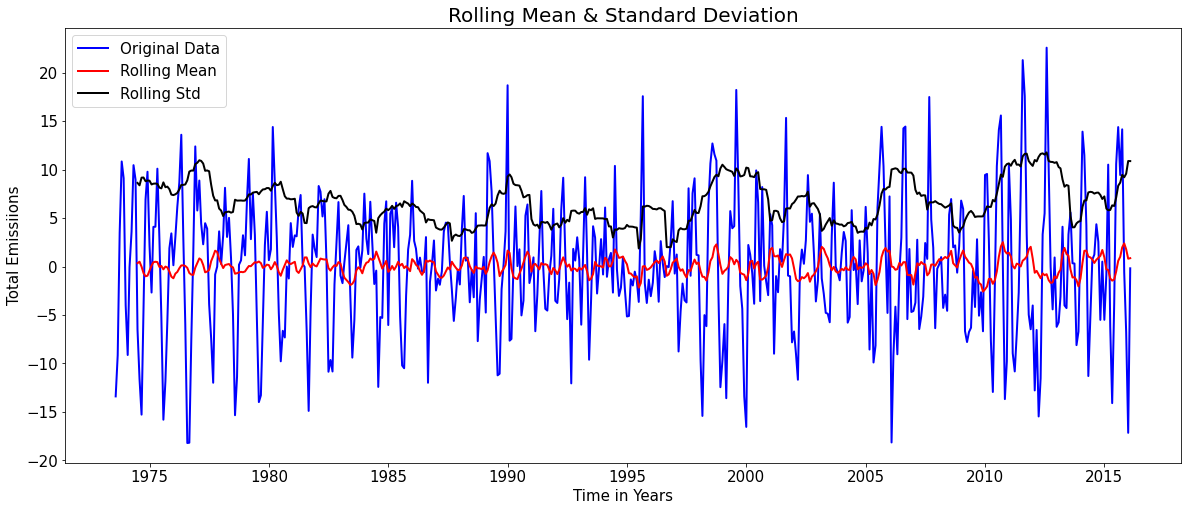

Test Statistic                -1.049037e+01
p-value                        1.151178e-18
#Lag Used                      1.400000e+01
Number of Observations Used    4.960000e+02
Critical Value (1%)           -3.443603e+00
Critical Value (5%)           -2.867385e+00
Critical Value (10%)          -2.569883e+00
dtype: float64
Hipotesis nol ditolak, data stasioner


In [30]:
mte_decompose = residual
mte_decompose.dropna(inplace=True)
TestStationaryPlot(mte_decompose)
TestStationaryAdFuller(mte_decompose)

## Build Seasonal ARIMA Model

### Plot the ACF and PACF charts and find the optimal parameters

- ***Autocorrelation Function (ACF)*** --> ukuran dari korelasi antara time series dengan lagged versionnya sendiri. 
- ***Partial Autocorrelation Function (PACF)*** --> ukuran korelasi antara time series dengan laggend versionnya sendiri tetapi setelah menghilangkan variasi yang telah dijelaskan oleh perbandingan intervensi

Oleh karena itu, langkah selanjutnya adalah menentukan parameter tuning (p dan q) model dengan melihat grafik ACF dan PACF.

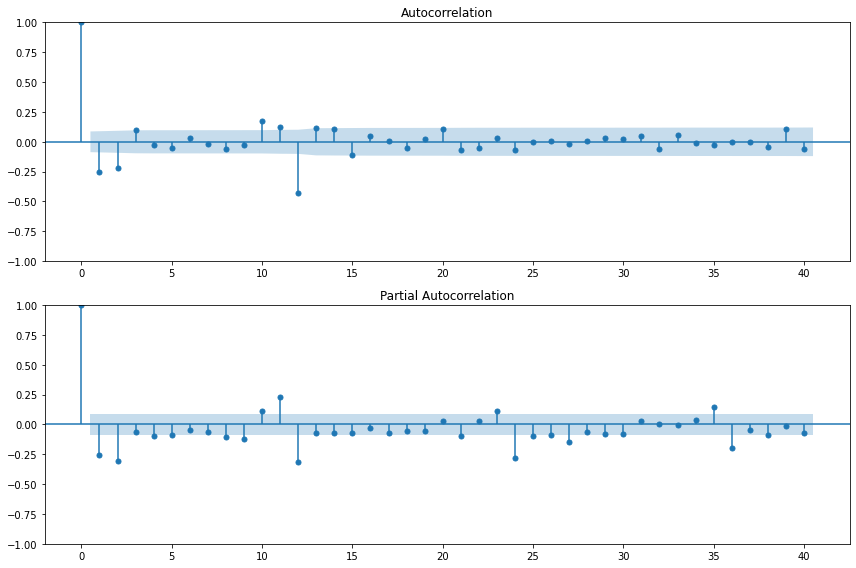

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)
plt.tight_layout()

### Grid Search

Untuk menemukan parameter optimal untuk model ARIMA menggunakan metode grafis bukanlah hal yang sepele dan memakan waktu. Kita akan memilih nilai parameter optimal secara sistematis menggunakan grid search (opsimasi hyperparameter).

Grid search secara iteratif mengeksplorasi kombinasi parameter yang berbeda. Untuk kombinasi parameter, kita akan menyesuaikan model seasonal ARIMA baru dengan fungsi SARIMAX() dari modul statsmodels dan menilai kualitasnya secara keseluruhan. Setelah kami explore seluruh lanskap parameter, set dari parameter kita akan menjadi parameter yang menghasilkan performa terbaik

In [32]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [33]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mte,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:6789.298270599557
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:6002.201147386868
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3763.4383774830867
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:3668.7261543326576
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:3770.412848507332
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:3745.257186546911
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:3676.5517185407125
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:3670.7251090854966
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:6114.19164145362
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:5399.273115026749
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:3573.3111506108353
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:3453.846494677164
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:3587.7032866873806
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:3527.1527330602994
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:3473.632882365313
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:3457.36156695668
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:4374.4993681040905
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:3980.342482986072
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:3618.

SARIMAX(1, 1, 1)x(0, 1, 1, 12) menghasilkan nilai AIC terendah yaitu 3227,6141. Oleh karena itu, kami akan menganggap ini sebagai opsi optimal dari semua kombinasi parameter. Kami telah mengidentifikasi kumpulan parameter yang menghasilkan model yang paling cocok untuk data deret waktu kami. Kita dapat melanjutkan untuk menganalisis model khusus ini secara lebih mendalam.

In [34]:
mod = sm.tsa.statespace.SARIMAX(mte, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                              SARIMAX Results                                               
Dep. Variable:     Total Energy Electric Power Sector CO2 Emissions   No. Observations:                  523
Model:                               SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1609.807
Date:                                              Tue, 21 Jun 2022   AIC                           3227.614
Time:                                                      21:25:53   BIC                           3244.440
Sample:                                                  01-31-1973   HQIC                          3234.219
                                                       - 07-31-2016                                         
Covariance Type:                                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

## Validating Prediction

Kami telah memperoleh model untuk time series yang sekarang dapat digunakan untuk menghasilkan forecasts. Kami mulai dengan membandingkan nilai prediksi dengan nilai nyata dari deret waktu, yang akan membantu kami memahami keakuratan forecast kami. Atribut get_prediction() dan conf_int() memungkinkan kita memperoleh nilai dan interval kepercayaan terkait untuk perkiraan deret waktu.

In [35]:
pred = results.get_prediction(start = 480, end = 523, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower Total Energy Electric Power Sector CO2 Emissions,upper Total Energy Electric Power Sector CO2 Emissions
2013-01-31,161.741247,185.947913
2013-02-28,140.065784,164.272449
2013-03-31,139.844217,164.050882
2013-04-30,135.304387,159.511052
2013-05-31,147.855272,172.061937


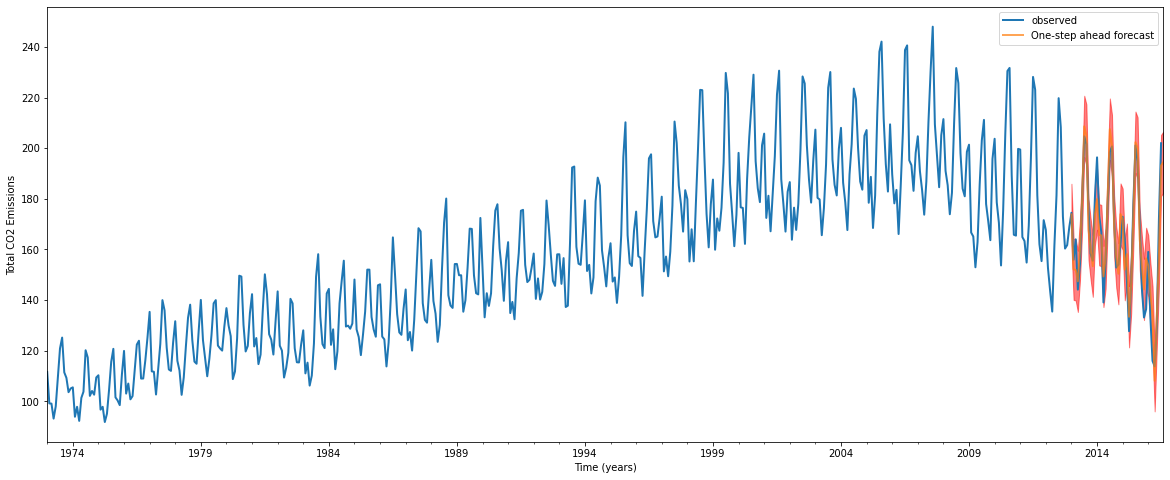

In [36]:
plt.figure(figsize=(20,8))
ax = mte['1973':].plot(label='observed', linewidth=2)
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, linewidth=2)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Total CO2 Emissions')
plt.legend()

plt.show()

Secara keseluruhan, perkiraan kami selaras dengan nilai sebenarnya dengan baik, menunjukkan perilaku serupa secara keseluruhan.

Hal ini juga berguna untuk mengukur keakuratan prakiraan kami. Kami akan menggunakan MSE (Mean Squared Error), yang merangkum kesalahan rata-rata dari perkiraan kami. Untuk setiap nilai prediksi, kami menghitung jaraknya ke nilai sebenarnya dan mengkuadratkan hasilnya. Hasilnya perlu dikuadratkan agar perbedaan positif/negatif tidak saling meniadakan.

In [37]:
mte_forecast = pred.predicted_mean
mte_truth = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'.format(np.sqrt(mse)))

The Mean Squared Error (MSE) of the forecast is 64.99
The Root Mean Square Error (RMSE) of the forcast: 8.0618


In [38]:
mte_pred_concat = pd.concat([mte_truth, mte_forecast])

Tujuan dari pengembangan model adalah untuk mendapatkan daya prediksi yang berkualitas baik dengan menggunakan dynamic forecast. Artinya, kami menggunakan informasi dari deret waktu hingga titik tertentu, dan setelah itu, perkiraan dihasilkan menggunakan nilai dari titik waktu perkiraan sebelumnya sebagai berikut:

In [39]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

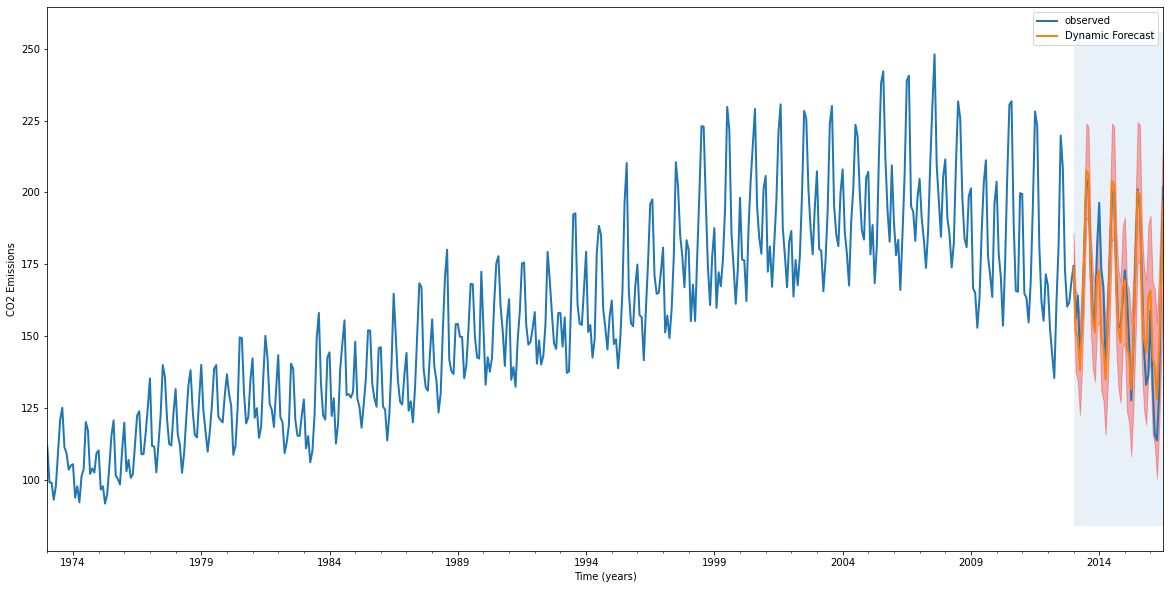

In [40]:
ax = mte['1973':].plot(label='observed', figsize=(20, 10), linewidth=2)
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax, linewidth=2)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-01-31'), 
                 mte.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Emissions')

plt.legend()
plt.show()

Dari memplot nilai pengamatan dan prakiraan dari deret waktu, kami melihat bahwa prakiraan keseluruhan akurat bahkan ketika kami menggunakan dynamic forecast. Semua nilai perkiraan (garis merah) cocok dengan data asli yang diamati (garis biru), dan berada dalam confidence interval.

In [41]:
# Extract the predicted and true values of our time series
mte_forecast = pred_dynamic.predicted_mean
mte_orginal = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_orginal) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_orginal)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 108.2
The Root Mean Square Error (RMSE) of the forcast: 10.4020


## Forecast

In [42]:
# Get forecast of 10 years or 120 months steps ahead in future
forecast = results.get_forecast(steps= 120)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

,lower Total Energy Electric Power Sector CO2 Emissions,upper Total Energy Electric Power Sector CO2 Emissions
2016-08-31,182.314772,206.521437
2016-09-30,146.551059,174.985779
2016-10-31,126.140163,156.325596
2016-11-30,120.035357,151.178018
2016-12-31,133.983022,165.774341


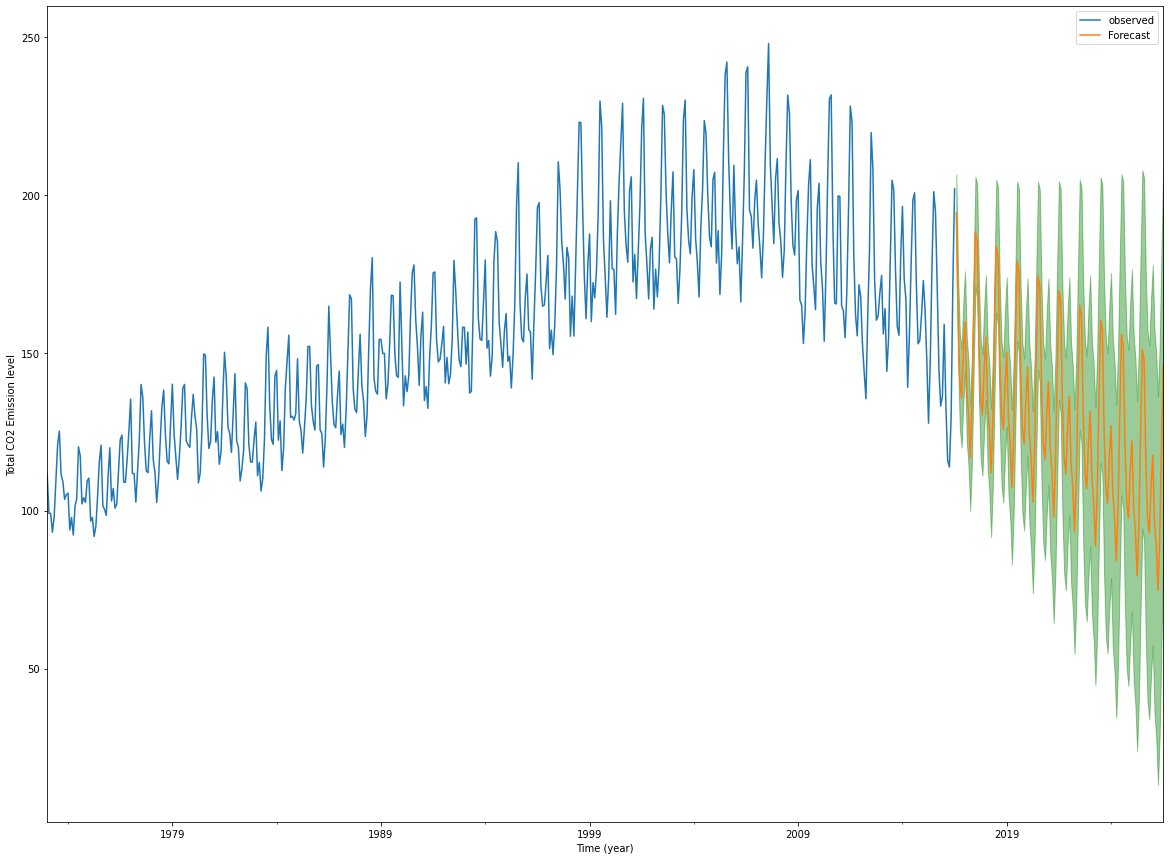

In [43]:
ax = mte.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('Total CO2 Emission level')

plt.legend()
plt.show()

Baik forecast dan interval kepercayaan terkait yang telah kami hasilkan sekarang dapat digunakan untuk mengeksplorasi dan memahami deret waktu lebih lanjut. Prakiraan tersebut menunjukkan bahwa total emisi CO2 diperkirakan akan terus menurun.